In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob

In [2]:
# CAMERA CALIBRATION

# find corners
def find_corners(img_list):
    objpoints = []  # 3D
    imgpoints = []  # 2D
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)  # create blank grid
    
    for image in img_list:   # for all images, create large array of 3D and 2D points
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    return imgpoints, objpoints


# calibrate camera
def calibrate_cam(img, imgpoints, objpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

image_folder = glob.glob("camera_cal/*")

imgpoints, objpoints = find_corners(image_folder)

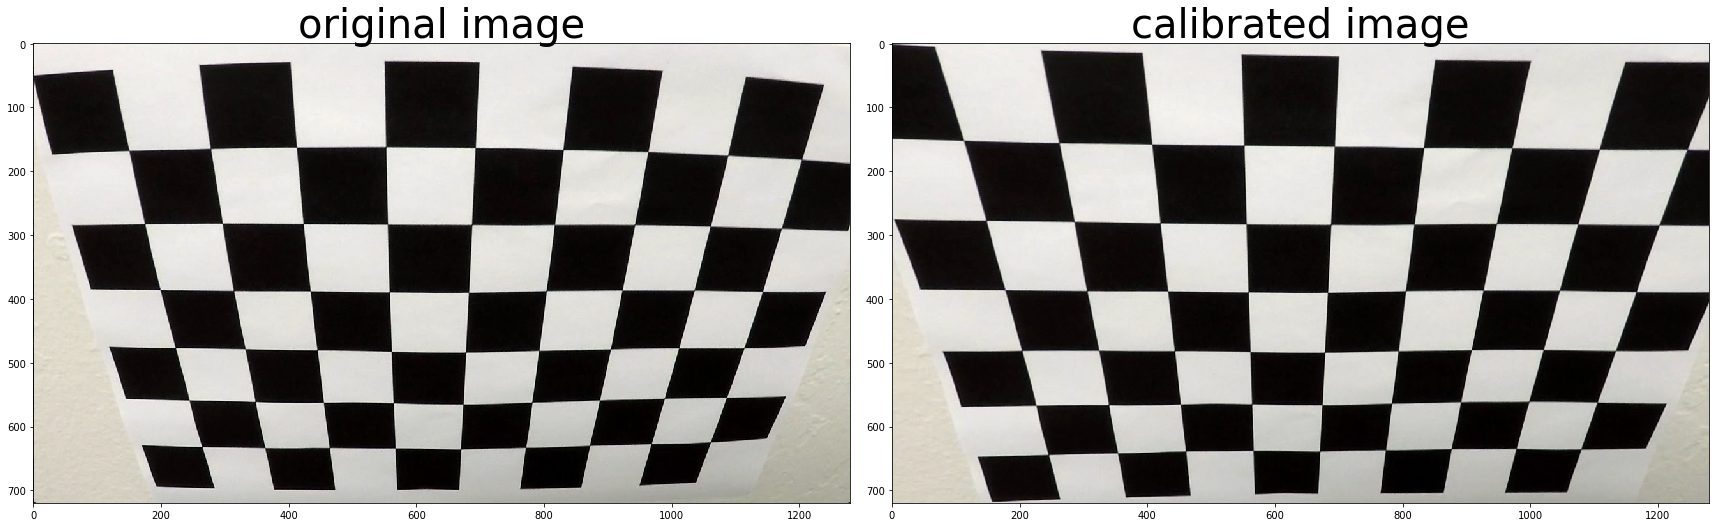

In [3]:
# TESTING CAMERA CALIBRATION

test_img_chessboard = mpimg.imread(image_folder[4])

dst = calibrate_cam(test_img_chessboard, imgpoints, objpoints)

# display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_img_chessboard)
ax1.set_title('original image', fontsize=40)

ax2.imshow(dst)
ax2.set_title('calibrated image', fontsize=40)
plt.show()

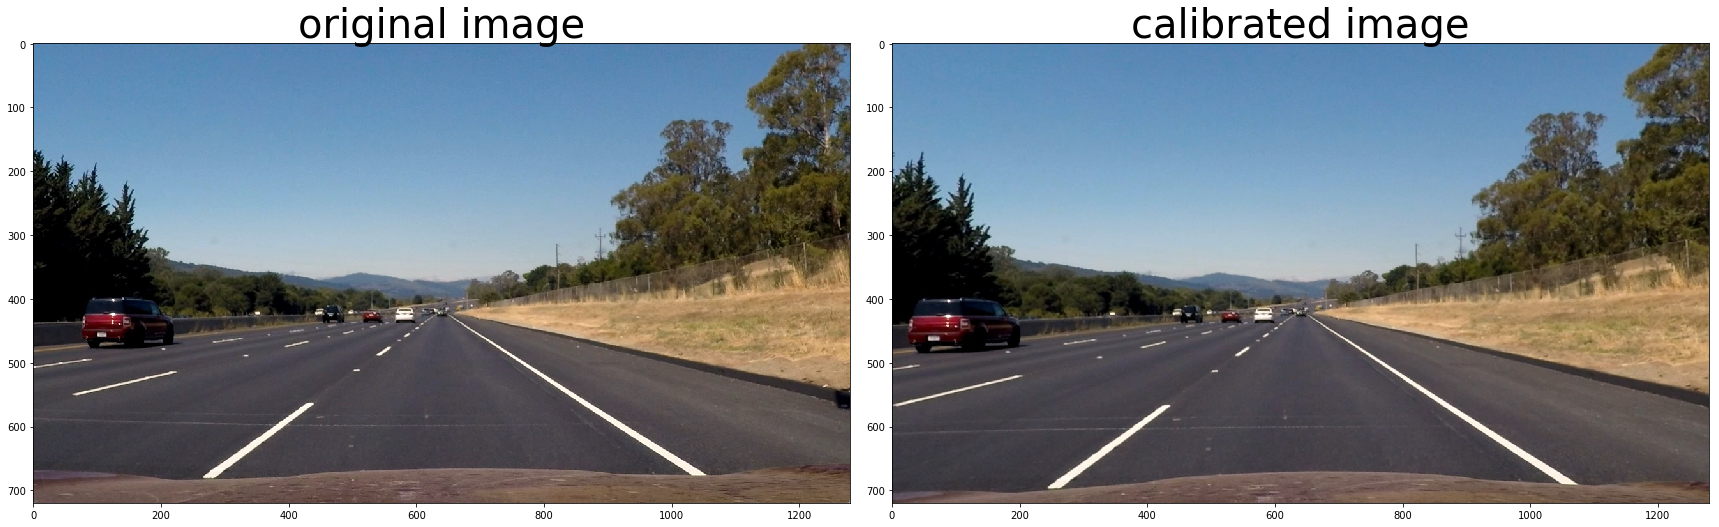

In [4]:
# CALIBRATOIN APPLIED TO ROAD IMAGE

road_image_folder = glob.glob("test_images/*")

orig_image = mpimg.imread(road_image_folder[3])

calibration_test_img = np.copy(orig_image)

calibrated_image = calibrate_cam(calibration_test_img, imgpoints, objpoints)

# display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(calibration_test_img)
ax1.set_title('original image', fontsize=40)

ax2.imshow(calibrated_image)
ax2.set_title('calibrated image', fontsize=40)
plt.show()

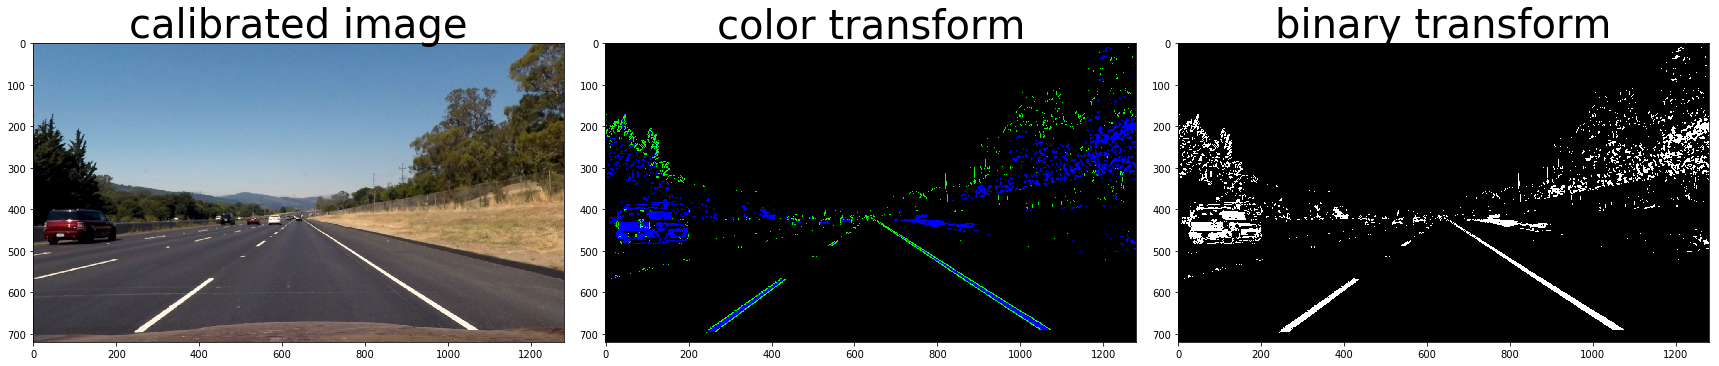

In [5]:
# THRESHOLDED BINARY IMAGE (color transforms, gradients, etc.)

def thresh_binary(img, s_thresh=(135, 255), sx_thresh=(45, 140)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_transform = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    binary_transform = np.zeros_like(sxbinary)
    binary_transform[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_transform, binary_transform
    
    
color_transform, binary_transform = thresh_binary(calibrated_image)

# display
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(calibrated_image)
ax1.set_title('calibrated image', fontsize=40)
ax2.imshow(color_transform)
ax2.set_title('color transform', fontsize=40)
ax3.imshow(binary_transform, cmap='gray')
ax3.set_title('binary transform', fontsize=40)
plt.show()

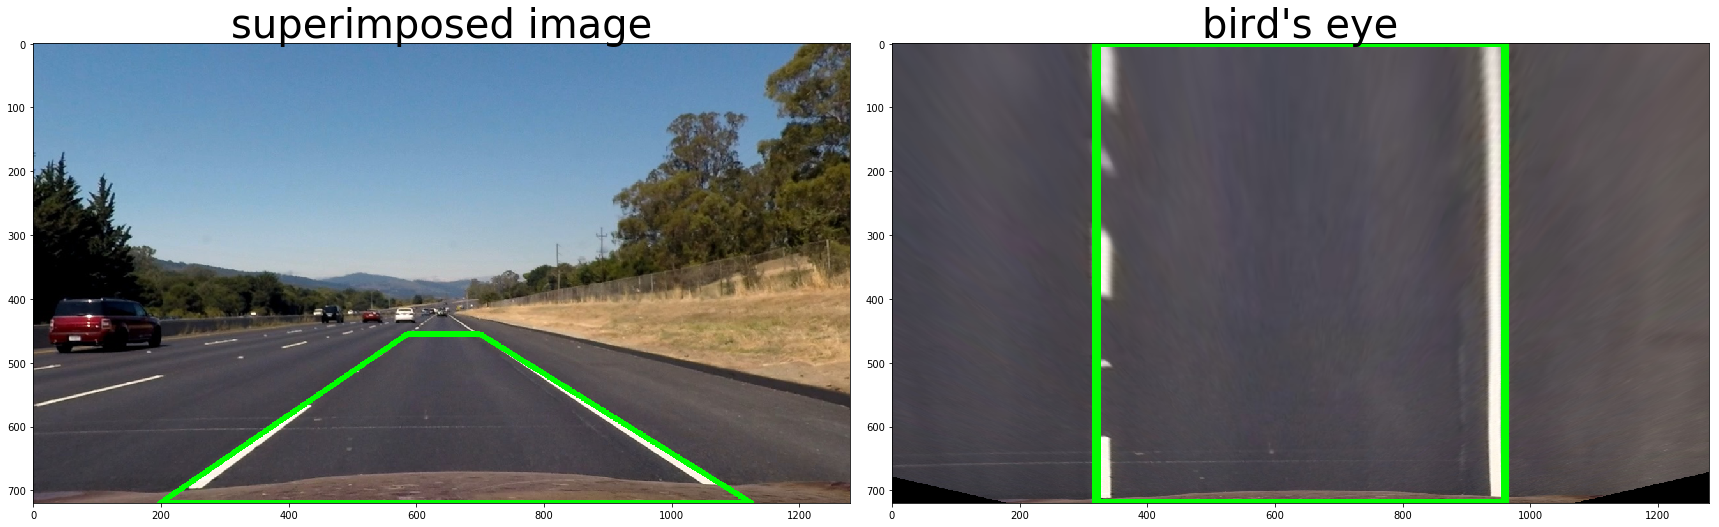

In [6]:
# PERSPECTIVE TRANSFORM

# need to run the perspective transform, display it, then have the same function for each picture (quick) 

def perspective_transform_matrix(img):

    img_size = (img.shape[1], img.shape[0])
    
    corners = np.float32(
        [[(img_size[0] / 2) - 54, img_size[1] / 2 + 95],
        [((img_size[0] / 6) - 15), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 60), img_size[1] / 2 + 95]])

    warped_corners = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    
    M = cv2.getPerspectiveTransform(corners, warped_corners)

    Minv = cv2.getPerspectiveTransform(warped_corners, corners)
    
    birds_eye = cv2.warpPerspective(img, M, img_size)
    birds_eye_with_box = cv2.polylines(birds_eye, np.int32([warped_corners]), True, (0, 255, 0), 12)

    superimposed_img = cv2.polylines(img, np.int32([corners]), True, (0, 255, 0), 8)
    
    return birds_eye, birds_eye_with_box, superimposed_img, M, Minv

perspective_transform_input = np.copy(calibrated_image)

birds_eye, birds_eye_with_box, superimposed_img, M, Minv = perspective_transform_matrix(perspective_transform_input)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(superimposed_img)
ax1.set_title('superimposed image', fontsize=40)
ax2.imshow(birds_eye_with_box)
ax2.set_title('bird\'s eye', fontsize=40)
plt.show()

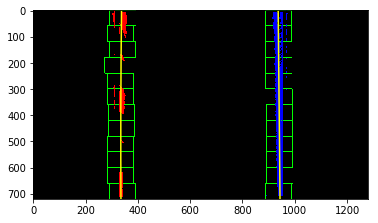

In [7]:
# FIND LANE BOUNDARY

# HISTOGRAM PEAKS

lane_finder_input, birds_eye_with_box, superimposed_img, M, Minv = perspective_transform_matrix(binary_transform)

def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

histogram = hist(lane_finder_input)


# from lesson:

def find_lane_pixels(lane_finder_input):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(lane_finder_input[lane_finder_input.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((lane_finder_input, lane_finder_input, lane_finder_input))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 12
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 60

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(lane_finder_input.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = lane_finder_input.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = lane_finder_input.shape[0] - (window+1)*window_height
        win_y_high = lane_finder_input.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(lane_finder_input):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(lane_finder_input)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, lane_finder_input.shape[0]-1, lane_finder_input.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
        
    return out_img, left_fit, right_fit, ploty


out_img, left_fit, right_fit, ploty = fit_polynomial(lane_finder_input)

plt.imshow(out_img)
plt.show()

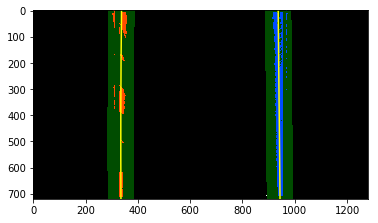

In [8]:
# FIND LANE BOUNDARY (part 2)

# left_fit = np.array([5.88716929e-06, -4.25458630e-02, 3.62626097e+02])
# right_fit = np.array([8.34396471e-06, 3.39224425e-02, 9.15527958e+02])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty


def search_around_poly(lane_finder_input, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 50

    # Grab activated pixels
    nonzero = lane_finder_input.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(lane_finder_input.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((lane_finder_input, lane_finder_input, lane_finder_input))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fitx, right_fitx, result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
left_fitx, right_fitx, result = search_around_poly(lane_finder_input, left_fit, right_fit)

# View your output
plt.imshow(result)
plt.show()

left curve radius:  13546.7264397 m
right curve radius:  131629.846524 m


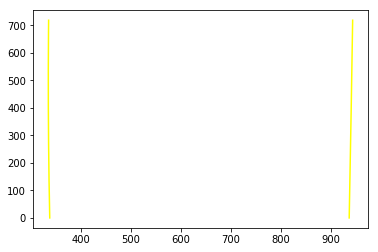

In [9]:
# DETERMINE CURVATURE OF LANE AND VEHICLE POSITION

out_img, left_fit, right_fit, ploty = fit_polynomial(lane_finder_input)

# left_fitx, right_fitx, ploty = search_around_poly(lane_finder_input.shape, left_fit, right_fit)

def measure_curvature_real(ploty, left_fitx, right_fitx):
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_curve = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_curve = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit_curve[1])**2)**1.5) / np.absolute(2*left_fit_curve[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit_curve[1])**2)**1.5) / np.absolute(2*right_fit_curve[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_real(ploty, left_fitx, right_fitx)

print('left curve radius: ', left_curverad, 'm')
print('right curve radius: ', right_curverad, 'm')

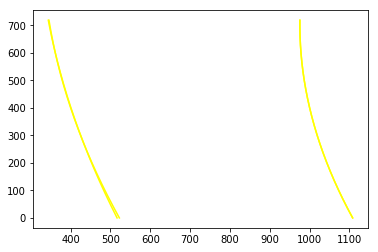

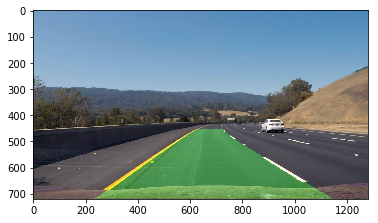

In [10]:
# WARP DETECTED LANE BOUNDARIES BACK ONTO ORIGINAL IMAGE

road_image_folder = glob.glob("test_images/*")

orig_image = mpimg.imread(road_image_folder[4])

calibrated_road_image = calibrate_cam(orig_image, imgpoints, objpoints)

color_transform, binary_transform2 = thresh_binary(calibrated_road_image)

perspective_transform_input = np.copy(binary_transform2)

lane_finder_input, birds_eye_with_box, superimposed_img, M, Minv = perspective_transform_matrix(perspective_transform_input)

out_img, left_fit, right_fit, ploty = fit_polynomial(lane_finder_input)

left_fitx, right_fitx, result2 = search_around_poly(lane_finder_input, left_fit, right_fit)

def redraw(orig_image, warped, left_fitx, right_fitx, ploty, Minv):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (orig_image.shape[1], orig_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)    
    
    return result

redrawn_image = redraw(orig_image, binary_transform2, left_fitx, right_fitx, ploty, Minv)
plt.show()

plt.imshow(redrawn_image)
plt.show()

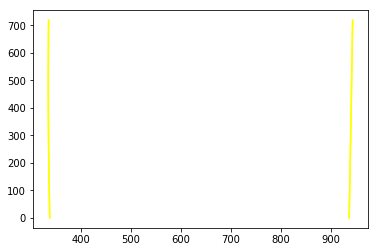

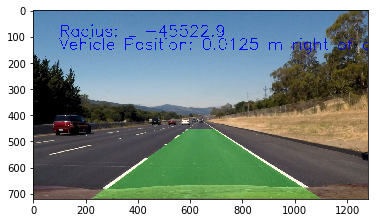

In [11]:
# PIPELINE

road_image_folder = glob.glob("test_images/*")

img = mpimg.imread(road_image_folder[3])


def pipeline(input_image):
    
    calibrated_road_image = calibrate_cam(input_image, imgpoints, objpoints)

    color_transform, binary_transform2 = thresh_binary(calibrated_road_image)

    perspective_transform_input = np.copy(binary_transform2)

    lane_finder_input, birds_eye_with_box, superimposed_img, M, Minv = perspective_transform_matrix(perspective_transform_input)

    out_img, left_fit, right_fit, ploty = fit_polynomial(lane_finder_input)

    left_fitx, right_fitx, result2 = search_around_poly(lane_finder_input, left_fit, right_fit)
    
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fitx, right_fitx)

    output_image = redraw(input_image, binary_transform2, left_fitx, right_fitx, ploty, Minv)
    
    center_lane = input_image.shape[1] / 2 - np.median(left_fitx + right_fitx) / 2
    
    rad_delta = (left_curverad - right_curverad) / 2
    
    if (left_curverad > (right_curverad + 200)):
        cv2.putText(output_image, "Radius: R %s" % float('%.6g' % (rad_delta + right_curverad)), (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
    else:
        cv2.putText(output_image, "Radius: L %s" % float('%.6g' % (rad_delta + left_curverad)), (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
    if (center_lane < 0):
        center_lane = np.abs(center_lane) * 3.7 / 700 # meters per pixel in x dimension
        cv2.putText(output_image, "Vehicle Position: %s m right of center" % float('%.3g' % (center_lane)), (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
    else:
        center_lane = center_lane * 3.7 / 700
        cv2.putText(output_image, "Vehicle Position: %s m right of center" % float('%.3g' % (center_lane)), (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)

    return output_image

pipeline_result = pipeline(img)

plt.show()
plt.imshow(pipeline_result)
plt.show()

[MoviePy] >>>> Building video output_images/project_video_processed.mp4
[MoviePy] Writing video output_images/project_video_processed.mp4


100%|█████████▉| 1260/1261 [13:26<00:00,  1.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_processed.mp4 

CPU times: user 10min 52s, sys: 18.9 s, total: 11min 11s
Wall time: 13min 29s


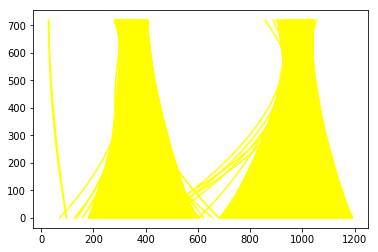

In [12]:
# CREATE VIDEO AND SAVE

from moviepy.editor import VideoFileClip

white_output = 'output_images/project_video_processed.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
